<a href="https://colab.research.google.com/github/ZahYou/my_other_project/blob/main/Nasas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Exploring
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from keras.callbacks import LearningRateScheduler

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report,auc
from scipy.stats import randint

# Model
from sklearn.ensemble import VotingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-07-08 20:02:40.625087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752004960.867749      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752004960.934763      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

### Goal:

Predict the Remaining Useful Life (RUL) of turbofan engines using time-series sensor data from the CMAPSS dataset. The aim is to

enable predictive maintenance—anticipating failures before they occur to optimize maintenance schedules and minimize downtime

1. Introduction & Problem Statement
2. Literature Review (highlighting state-of-the-art and gaps)
3. Dataset Exploration & Preprocessing
4. Feature Engineering & Selection
5. Model Design (with justifications)
6. Training & Evaluation
7. Interpretability & Uncertainty Quantification
8. Results & Discussion
9. Conclusions & Future Work

In [6]:
# Define Columns name for indexing
index_name = ["unit_nr", "time_in_cycles"]
settings_name = ["op_setting_1","op_setting_2", "op_setting_3"]
sensors_name = [f"sensor_{i}" for i in range(22)]

cols_name = index_name + settings_name + sensors_name
#Load train,test and target with columns name
path_train = "/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt"
path_test = "/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt"
train_df =  pd.read_csv(path_train,sep = " ",header=None)
test_df = pd.read_csv(path_test,sep = " ",header=None)

columns = ['engine_number', 'time_in_cycles'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 24)]
train_df.columns = columns
test_df.columns = columns

test_df.columns = columns

test_df = test_df.iloc[0:].reset_index(drop=True)

test_df = test_df.drop(index=0).reset_index(drop=True)
train_df.columns = columns

train_df = train_df.iloc[0:].reset_index(drop=True)

train_df = train_df.drop(index=0).reset_index(drop=True)

# drop nan columns
train_df = train_df.iloc[:, :-2]
test_df = test_df.iloc[:, :-2]

train_df.head()

,engine_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669


In [7]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (20630, 26)
Test shape: (13095, 26)


In [8]:
def search_constant(df):
    return df.columns[df.nunique() == 1].to_list()

In [9]:
#train_df = train_df.drop(columns=search_constant(train_df))
#test_df = test_df.drop(columns=search_constant(test_df))


In [10]:
train_df.head()

,engine_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669


### How to Generate RUL Labels

#### For each engine (unit), RUL at each cycle is:  RUL = max_cycle_for_engine − current_cycle


In [11]:
# Group by eingin and get the max cycle for each
train_df['time_in_cycles'] = pd.to_numeric(train_df['time_in_cycles'], errors='coerce')

rul = pd.DataFrame(train_df.groupby('engine_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['engine_number', 'max_time_in_cycles']
train_df = train_df.merge(rul, on='engine_number')

train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop('max_time_in_cycles', axis=1, inplace=True)

train_df['RUL'] = train_df['RUL'].apply(lambda x: min(x, 130))

#time_window = 50
#train_df['label'] = train_df['RUL'].apply(lambda x: 1 if x > time_window else 0)

In [12]:
train_df.head()

,engine_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,130


### [Raw Clean Data] (no NaNs)

  ⮕ Keep all sensors, even low-variance ones

  ⮕ Normalize (StandardScaler or MinMax)

  ⮕ Generate time series sequences (sliding window)

  ⮕ Train a baseline deep model (e.g., LSTM or Conv1D)

  ⮕ Evaluate: MAE, RMSE, error curves vs. cycle

  ⮕ THEN perform sensor ablation / feature pruning


In [28]:
from sklearn.preprocessing import StandardScaler

# Hash operating conditions
train_df["op_hash"] = train_df[["op_setting_1", "op_setting_2"]].round(3).astype(str).agg("_".join, axis=1)
test_df["op_hash"] = test_df[["op_setting_1", "op_setting_2"]].round(3).astype(str).agg("_".join, axis=1)

# Columns to normalize
feature_cols = [
    'op_setting_1', 'op_setting_2','op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
    'sensor_20', 'sensor_21'
]
train_df[feature_cols] = train_df[feature_cols].astype("float32")
test_df[feature_cols]  = test_df[feature_cols].astype("float32")

scalers = {}

for op_id, group in train_df.groupby("op_hash"):
    scaler = StandardScaler()
    scaler.fit(group[feature_cols])
    scalers[op_id] = scaler
    
    # Apply scaler to train group
    scaled = scaler.transform(group[feature_cols])
    train_df.loc[group.index, feature_cols] = scaled

global_scaler = StandardScaler()
global_scaler.fit(train_df[feature_cols]) # Global fallback trained on full train_df

for op_id, group in test_df.groupby("op_hash"):
    if op_id in scalers:
        scaler = scalers[op_id]
        print(f"✅ Normalizing with op_hash scaler for {op_id}")
    else:
        scaler = global_scaler
        print(f"⚠️ Warning: op_hash {op_id} in test not seen in train. Using global scaler instead.")
    
    scaled_features = scaler.transform(group[feature_cols])
    test_df.loc[group.index, feature_cols] = scaled_features


⚠️ Warning: op_hash -0.042_-0.008 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_-0.35 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_-0.692 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_-1.035 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_-1.377 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_-1.719 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_0.334 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_0.676 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_1.018 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_1.361 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_hash -0.042_1.703 in test not seen in train. Using global scaler instead.
⚠️ Warning: op_h

Before:

Some test samples were left raw (unscaled)

This broke the assumptions the model trained under (mean 0, std 1)

Now:

All test samples — seen or unseen op_hash — are standardized

Your model will behave more predictably on test engines



In [ ]:
"""# Mean ~0, std ~1
print(train_df[feature_cols].mean())
print(train_df[feature_cols].std())

# Confirm no leakage
assert 'RUL' in train_df.columns
assert train_df['RUL'].max() > 0"""

#### Generate Time-Series Sequences (Sliding Window)
Now reshape the data: for each engine, extract sliding windows of size N (e.g. 30 time steps), each labeled with the RUL at the final timestep.

In [ ]:
#sample_engine = train_df[train_df["engine_number"] == 1]

In [ ]:
"""fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sensors over Cycle Time", fontsize=18, y=0.95)
for sensor, ax in zip(sensors_name, axs.ravel()):
    ax.plot(sample_engine['time_in_cycles'], sample_engine[sensor])
    #ax.axvline(x = 200, color = "red")
    ax.set_xlabel(f"{sensor}", color = "green")


plt.show()
# We see a common change on point cycle 200"""

In [ ]:
"""fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Sensors over Cycle Time", fontsize=18, y=0.95)
for sensor, ax in zip(sensors_name, axs.ravel()):
    ax.boxplot(train_df[sensor])
    #ax.axvline(x = 200, color = "red")
    ax.set_xlabel(f"{sensor}", color = "green")


plt.show()"""

In [ ]:
#pd.DataFrame(train_df,columns=['sensor_{}'.format(i) for i in range(1,22)])

In [17]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2025-07-08 20:06:04.135362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

# TF Dataset Generator
def make_tf_sliding_window_dataset(data, window_size, batch_size):
    """
    data: NumPy array of shape (timesteps, num_features + 1)
    window_size: length of input sequence
    batch_size: batch size for training
    """

    total_features = data.shape[1] - 1 # Without RUL
    ds = tf.data.Dataset.from_tensor_slices(data)

    # Create sliding windows of size (window_size + 1)
    ds = ds.window(window_size + 1, shift= 1, drop_remainder= True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))

    # Split into (X,y)
    ds = ds.map(lambda window: (window[:-1, :total_features], # X: first window_size rows, all features
                                window[-1,-1]))  # y: last row's RUL
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
"""for x_batch, y_batch in train_ds.take(1):
    print("Input batch shape:", x_batch.shape)  # Should be (batch_size, window_size, num_features)
    print("Label batch shape:", y_batch.shape)  # Should be (batch_size,)
    print("First X sample:\n", x_batch[0].numpy())
    print("First y sample:", y_batch[0].numpy())"""

In [ ]:
# Flattened Dataset Generator
def make_tf_sliding_dataset(data, window_size, batch_size):
  total_features = data.shape[1] -1 # -1 because last column is RUL

  ds = tf.data.Dataset.from_tensor_slices(data)
  ds = ds.window(window_size +1, shift = 1, drop_remainder= True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))

  # Flatten input window
  ds = ds.map(lambda window: (tf.reshape(window[:-1, : total_features], [-1]), #(window_size * num_features,)
                              window[-1,-1])) # scaler RUL
  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_flat_dataset_all_engines_normal(df, feature_cols, window_size=30, batch_size=64):
    """
    Creates a flat tf.data.Dataset across all engines.

    Args:
        df: full DataFrame including all engines
        feature_cols: list of feature column names (sensors + op_settings)
        window_size: length of sliding window
        batch_size: batch size for training

    Returns:
        tf.data.Dataset
    """
    all_datasets = []

    for engine_id in df['engine_number'].unique():
        engine_df = df[df['engine_number'] == engine_id]
        data = engine_df[feature_cols + ['RUL']].values

        # Skip engines with short life
        if data.shape[0] <= window_size:
            continue

        ds = tf.data.Dataset.from_tensor_slices(data)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(window_size + 1))

        num_features = len(feature_cols)

        # Flatten window and extract RUL
        ds = ds.map(lambda w: (
            tf.reshape(w[:-1, :num_features], [-1]),  # flatten window
            w[-1, -1]  # RUL label
        ))

        all_datasets.append(ds)

    # Combine all engines’ datasets
    full_ds = all_datasets[0]
    for ds in all_datasets[1:]:
        full_ds = full_ds.concatenate(ds)

    return full_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


CURRENT: Simple Dense Model (MAE ~13.4)
    
STAGE 1: LSTM/Conv1D + Better RUL label + Optimized window size
    
STAGE 2: Add deltas, regime normalization, engineered features
    
STAGE 3: Hyperparam tuning + ensembles + smoothing



GOAL: MAE ≤ 10, RMSE ≤ 13, R² ≥ 0.85


In [20]:
#make_sequence_dataset_all_engines() for LSTM.
def make_sequence_dataset_all_engines(df, feature_cols, window_size=30, batch_size=64):
    all_datasets = []

    for engine_id in df['engine_number'].unique():
        engine_df = df[df['engine_number'] == engine_id]
        data = engine_df[feature_cols + ['RUL']].values

        if data.shape[0] <= window_size:
            continue

        ds = tf.data.Dataset.from_tensor_slices(data)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(window_size + 1))

        num_features = len(feature_cols)

        ds = ds.map(lambda window: (
            window[:-1, :num_features],  # X: sequence, shape = (window_size, num_features)
            window[-1, -1]               # y: scalar RUL at last timestep
        ))

        all_datasets.append(ds)

    # Combine all engines
    full_ds = all_datasets[0]
    for ds in all_datasets[1:]:
        full_ds = full_ds.concatenate(ds)

    return full_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [29]:
# split the data by engine
engine_ids = train_df["engine_number"].unique()

# Shuffle and split by engine ID
np.random.seed(42)
np.random.shuffle(engine_ids)

train_ids = engine_ids[:int(0.7* len(engine_ids))] # 70% train
val_ids = engine_ids[int(0.7 * len(engine_ids)): int(0.85 * len(engine_ids))] # 15% val
test_ids = engine_ids[int(0.85 * len(engine_ids)):] # 15% val
# Filter DataFrames
train_df_split = train_df[train_df["engine_number"].isin(train_ids)]
val_df_split = train_df[train_df["engine_number"].isin(val_ids)]
test_df_split = train_df[train_df["engine_number"].isin(test_ids)]
# Build data
train_ds = make_sequence_dataset_all_engines(train_df_split, feature_cols, window_size=30, batch_size=64)
val_ds   = make_sequence_dataset_all_engines(val_df_split, feature_cols, window_size=30, batch_size=64)
test_ds  = make_sequence_dataset_all_engines(test_df_split, feature_cols, window_size=30, batch_size=64)

In [30]:
for x_batch, y_batch in train_ds.take(1):
    print("Input shape:", x_batch.shape)  # should be (batch_size, 30, num_features)
    print("Label shape:", y_batch.shape)  # should be (batch_size,)


Input shape: (64, 30, 24)
Label shape: (64,)


In [24]:
from tensorflow.keras import layers, models

window_size = 80
num_features = 24

model = models.Sequential([
    layers.Input(shape=(window_size, num_features)),  # (30, 23)
    layers.LSTM(64, return_sequences=False),          # outputs: (batch_size, 64)
    layers.Dense(32, activation='relu'),              # (batch_size, 32)
    layers.Dense(1)                                   # (batch_size, 1) → RUL
])

model.compile(
    optimizer='adam',
    loss='mae',              
    metrics=['mae', 'mse']   
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

history.model.evaluate(test_ds)

Epoch 1/10
    191/Unknown 8s 23ms/step - loss: 77.0334 - mae: 77.0334 - mse: 7768.0493

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 77.0089 - mae: 77.0089 - mse: 7764.0928 - val_loss: 62.7923 - val_mae: 62.7923 - val_mse: 5438.8979
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 55.6445 - mae: 55.6445 - mse: 4344.2314 - val_loss: 43.7604 - val_mae: 43.7604 - val_mse: 2485.4126
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 41.1884 - mae: 41.1884 - mse: 2185.4622 - val_loss: 39.1193 - val_mae: 39.1193 - val_mse: 1913.5948
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 38.3048 - mae: 38.3048 - mse: 1862.6024 - val_loss: 38.4403 - val_mae: 38.4403 - val_mse: 1884.3241
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 37.9462 - mae: 37.9462 - mse: 1861.6716 - val_loss: 38.3219 - val_mae: 38.3219 - val_mse: 1893.9741
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 37.8972 - mae: 37.8972 - mse: 1873.7799 - val_loss: 38.2936 - val_mae: 38.2936 - val_mse: 1899.2819
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29

[38.249969482421875, 38.249969482421875, 1903.152099609375]

In [31]:

results = []

window_sizes = [30, 50, 70, 80]
batch_size = 64
num_features = len(feature_cols)

for w in window_sizes:
    print(f"\n Training model with window_size = {w}")

    # 1. Build datasets
    train_ds = make_sequence_dataset_all_engines(train_df_split, feature_cols, window_size=w, batch_size=batch_size)
    val_ds = make_sequence_dataset_all_engines(val_df_split, feature_cols, window_size=w, batch_size=batch_size)
    test_ds = make_sequence_dataset_all_engines(test_df_split, feature_cols, window_size=w, batch_size=batch_size)

    # 2. Define model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(w, num_features)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

    # 3. Train
    model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=0)

    # 4. Evaluate on test
    mae, mse = model.evaluate(test_ds, verbose=0)[1:]  # [loss, mae, mse] → skip loss
    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # 5. Save results
    results.append({
        'window_size': w,
        'model_type': 'LSTM',
        'num_features': num_features,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MSE': round(mse, 2)
    })

# 6. Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n Results Summary:")
print(results_df)



 Training model with window_size = 30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MAE: 18.88, RMSE: 26.47

 Training model with window_size = 50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MAE: 16.22, RMSE: 23.78

 Training model with window_size = 70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MAE: 15.46, RMSE: 22.20

 Training model with window_size = 80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MAE: 18.88, RMSE: 25.53

 Results Summary:
   window_size model_type  num_features    MAE   RMSE     MSE
0           30       LSTM            24  18.88  26.47  700.46
1           50       LSTM            24  16.22  23.78  565.63
2           70       LSTM            24  15.46  22.20  493.06
3           80       LSTM            24  18.88  25.53  651.59


In [32]:

window_size = 70
num_features = 24

model = models.Sequential([
    layers.Input(shape=(window_size, num_features)),  # (30, 24)
    layers.LSTM(64, return_sequences=False),          # outputs: (batch_size, 64)
    layers.Dense(32, activation='relu'),              # (batch_size, 32)
    layers.Dense(1)                                   # (batch_size, 1) → RUL
])

model.compile(
    optimizer='adam',
    loss='mae',              
    metrics=['mae', 'mse']   
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

history.model.evaluate(test_ds)

Epoch 1/10
    136/Unknown 9s 42ms/step - loss: 59.6072 - mae: 59.6072 - mse: 5137.3804

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 59.5067 - mae: 59.5067 - mse: 5124.1890 - val_loss: 35.3698 - val_mae: 35.3698 - val_mse: 1874.2443
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 27.6603 - mae: 27.6603 - mse: 1274.0635 - val_loss: 20.8083 - val_mae: 20.8083 - val_mse: 642.0071
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 17.4628 - mae: 17.4628 - mse: 516.8900 - val_loss: 19.2759 - val_mae: 19.2759 - val_mse: 599.3884
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 15.8806 - mae: 15.8806 - mse: 436.7550 - val_loss: 21.1580 - val_mae: 21.1580 - val_mse: 725.3654
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 15.8536 - mae: 15.8536 - mse: 443.7166 - val_loss: 16.9407 - val_mae: 16.9407 - val_mse: 481.7675
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 14.1358 - mae: 14.1358 - mse: 358.0416 - val_loss: 16.7042 - val_mae: 16.7042 - val_mse: 480.2836
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step 

[12.601237297058105, 12.601237297058105, 305.5946044921875]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


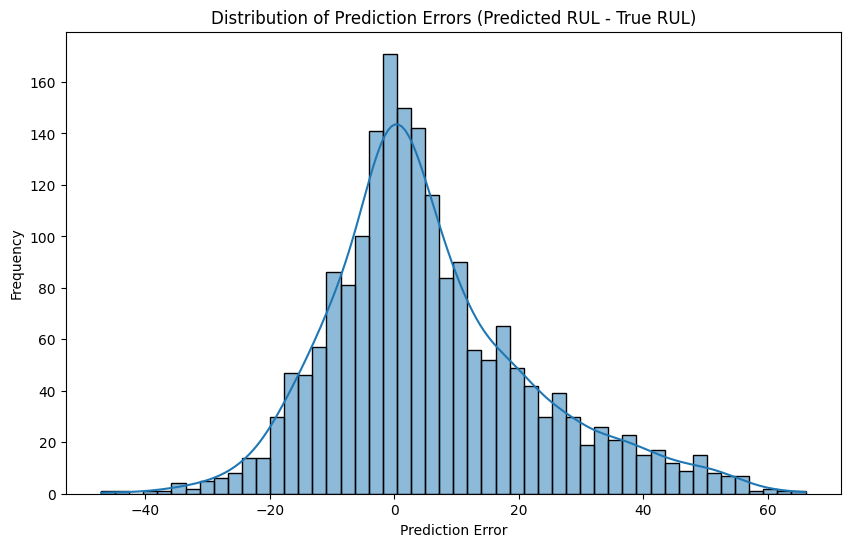

 mean absolute error 12.6
 root mean squared error 17.48113268641366
 R2 score 0.82


In [33]:
# y_true and y_pred for test_ds
# Plot prediction error distribution and residuals

# Get true RUL values from the test_ds
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Get predicted RUL values from the test_ds
y_pred = model.predict(test_ds).flatten()

# Calculate prediction errors
errors = y_pred - y_true

# Visualize Prediction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution of Prediction Errors (Predicted RUL - True RUL)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


def score_func(y_true,y_pred):
    lst = [
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]

    print(f' mean absolute error {lst[0]}')
    print(f' root mean squared error {lst[1]}')
    print(f' R2 score {lst[2]}')

score_func(y_true, y_pred)

In [36]:
# asymetric loss func

def asymetric_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    error = y_pred - y_true
    factor = tf.where(error > 0, 2.0, 1.0) # Penalisation 
    return tf.reduce_mean(factor * tf.abs(error))
    
asymetric_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=21.74039077758789>